In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, Dropout, Conv2DTranspose, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import cv2


In [ ]:
# Function to load data. If 'is_groundtruth' is True, the images are loaded in grayscale.
def load_data(data_path, is_groundtruth=False):
    data = []
    for filename in os.listdir(data_path):
        if is_groundtruth:
            img = cv2.imread(os.path.join(data_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is None or img.shape[0] == 0 or img.shape[1] == 0:
                continue
        else:
            img = cv2.imread(os.path.join(data_path, filename))
# Resize images to 128x128 and normalize it
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        data.append(img)
    return np.array(data)

# Function to preprocess the groundtruth data by converting pixel values to binary.
def preprocess_groundtruth_data(data):
    return (data > 0).astype(int)


In [ ]:
# Function to build the FCN model using a pre-trained VGG16 network as the encoder.
def build_model(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    
    # Add convolutional layers
    x = vgg16.get_layer('block5_pool').output
    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1000, (1, 1), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

    # Add upsampling layers and skip connections for the decoder part.
    x = Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same')(x)
    pool4 = vgg16.get_layer('block4_pool').output
    x = Add()([x, Conv2D(512, (1, 1), activation='relu', padding='same')(pool4)])

    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(x)
    pool3 = vgg16.get_layer('block3_pool').output
    x = Add()([x, Conv2D(256, (1, 1), activation='relu', padding='same')(pool3)])

    x = Conv2DTranspose(1, (16, 16), strides=(8, 8), padding='same')(x)
    x = Activation('sigmoid')(x)

    # Compile the model
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model


In [ ]:
# Function to visualize predictions with a side-by-side comparison of input, groundtruth, and predicted masks.
def visualize_predictions(X_test, y_test, y_pred):
    n_examples = 5
    fig, ax = plt.subplots(n_examples, 3, figsize=(10, 20))

    for i in range(n_examples):
        ax[i, 0].imshow(X_test[i])
        ax[i, 0].set_title("Input")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(y_test[i].squeeze(), cmap="gray")
        ax[i, 1].set_title("Ground truth")
        ax[i, 1].axis("off")

        ax[i, 2].imshow(y_pred[i].squeeze(), cmap="gray")
        ax[i, 2].set_title("Predicted")
        ax[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Function to create a video visualization of the segmentation results.
def create_video(X_test, y_pred, output_path='segmentation_output.mp4', frame_size=(256, 256), frame_rate=10.0):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, frame_size)
    
    for i in range(len(X_test)):
        input_image = cv2.resize((X_test[i] * 255).astype('uint8'), frame_size)
        predicted_mask = cv2.resize((y_pred[i].squeeze() * 255).astype('uint8'), frame_size)
        
        predicted_mask_colored = cv2.applyColorMap(predicted_mask, cv2.COLORMAP_JET)
        overlay_image = cv2.addWeighted(input_image, 0.7, predicted_mask_colored, 0.3, 0)
        
        out.write(overlay_image)
    
    out.release()


Epoch 1/5
47/47 [==============================] - 313s 7s/step - loss: 0.1874 - val_loss: 0.0616
Epoch 2/5
47/47 [==============================] - 314s 7s/step - loss: 0.0421 - val_loss: 0.0304
Epoch 3/5
47/47 [==============================] - 314s 7s/step - loss: 0.0246 - val_loss: 0.0229
Epoch 4/5
47/47 [==============================] - 311s 7s/step - loss: 0.0197 - val_loss: 0.0187
Epoch 5/5
8/8 [==============================] - 13s 2s/step - loss: 0.0189
Test loss: 0.018935319036245346
8/8 [==============================] - 13s 2s/step


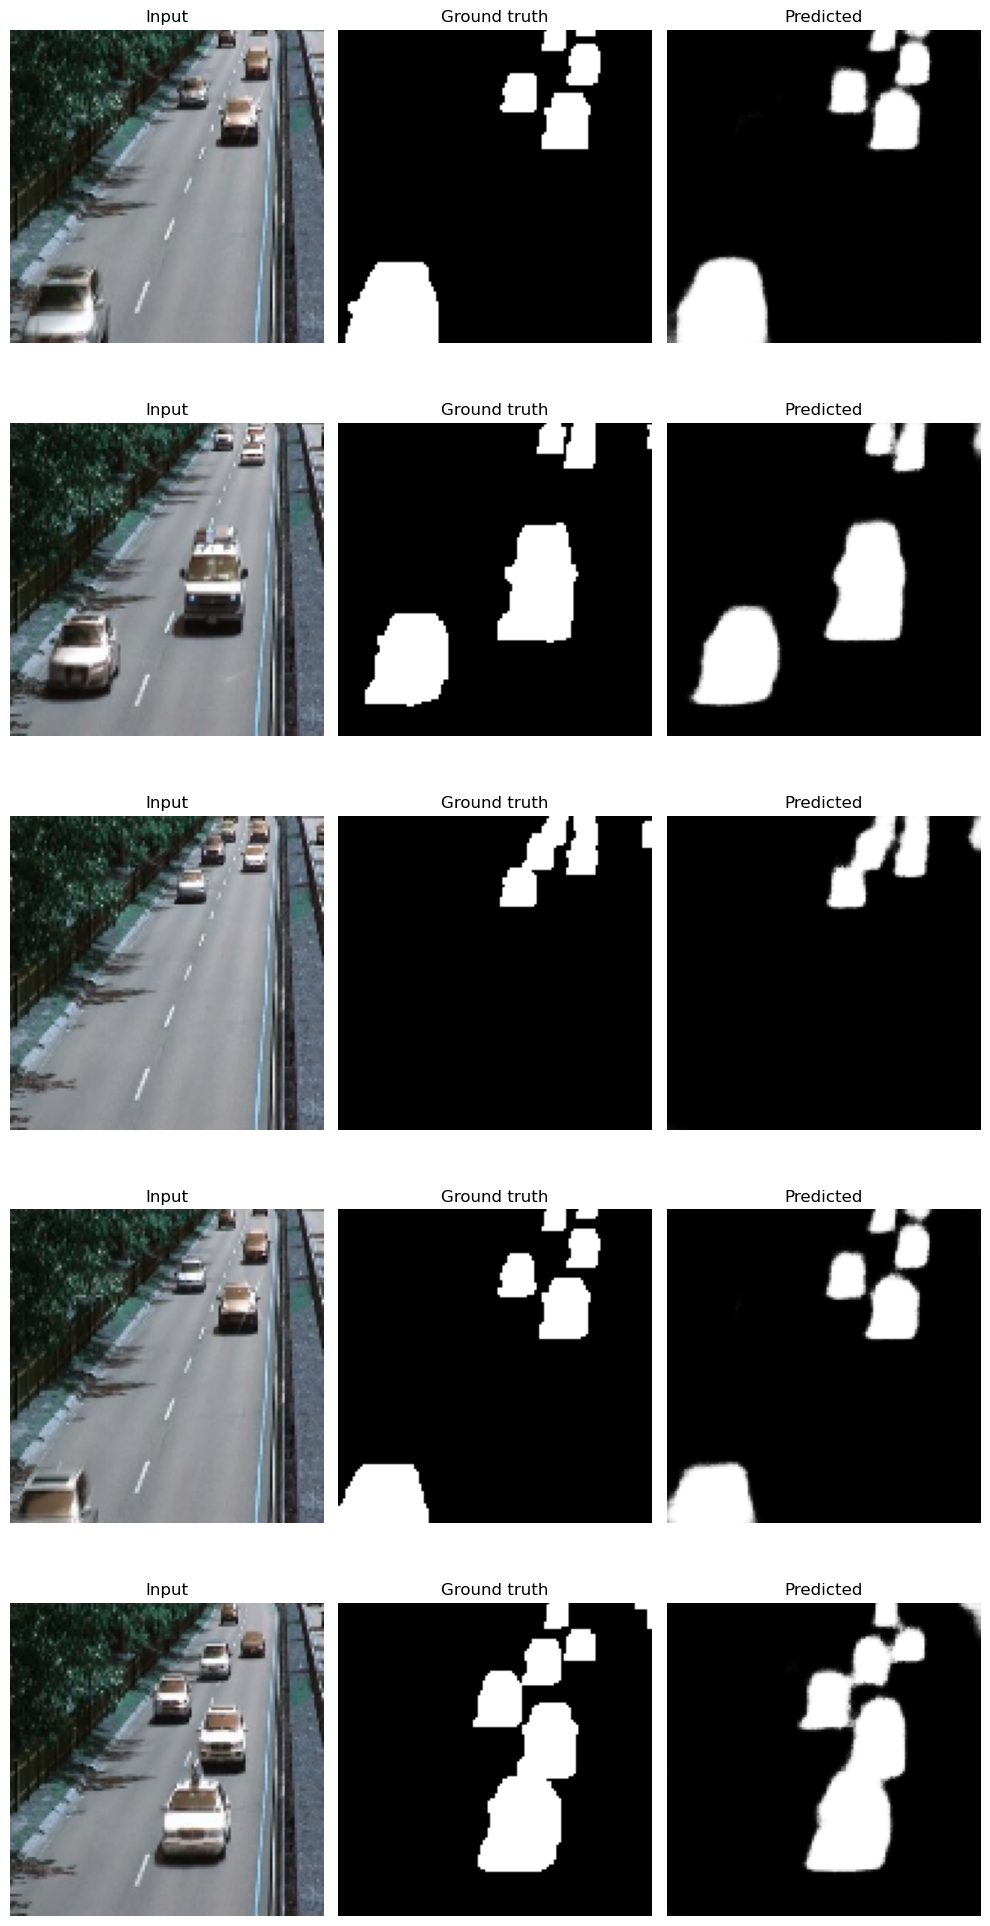

In [14]:

# Main script starts here: Load data, preprocess it, build and train the model, then visualize predictions and create a video output/
input_data_path = 'input'
groundtruth_data_path = 'groundtruth'

input_data = load_data(input_data_path)
groundtruth_data = load_data(groundtruth_data_path, is_groundtruth=True)

X_train_val, X_test, y_train_val, y_test = train_test_split(input_data, groundtruth_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Preprocess groundtruth data
y_train = preprocess_groundtruth_data(y_train)
y_val = preprocess_groundtruth_data(y_val)
y_test = preprocess_groundtruth_data(y_test)

# Build and train the model
model = build_model()
model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_val, y_val))

# Evaluate the model on the test set and print the test loss
test_loss = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)

# Predict on test data and visualize the results
y_pred = model.predict(X_test)
visualize_predictions(X_test, y_test, y_pred)
create_video(X_test, y_pred)
